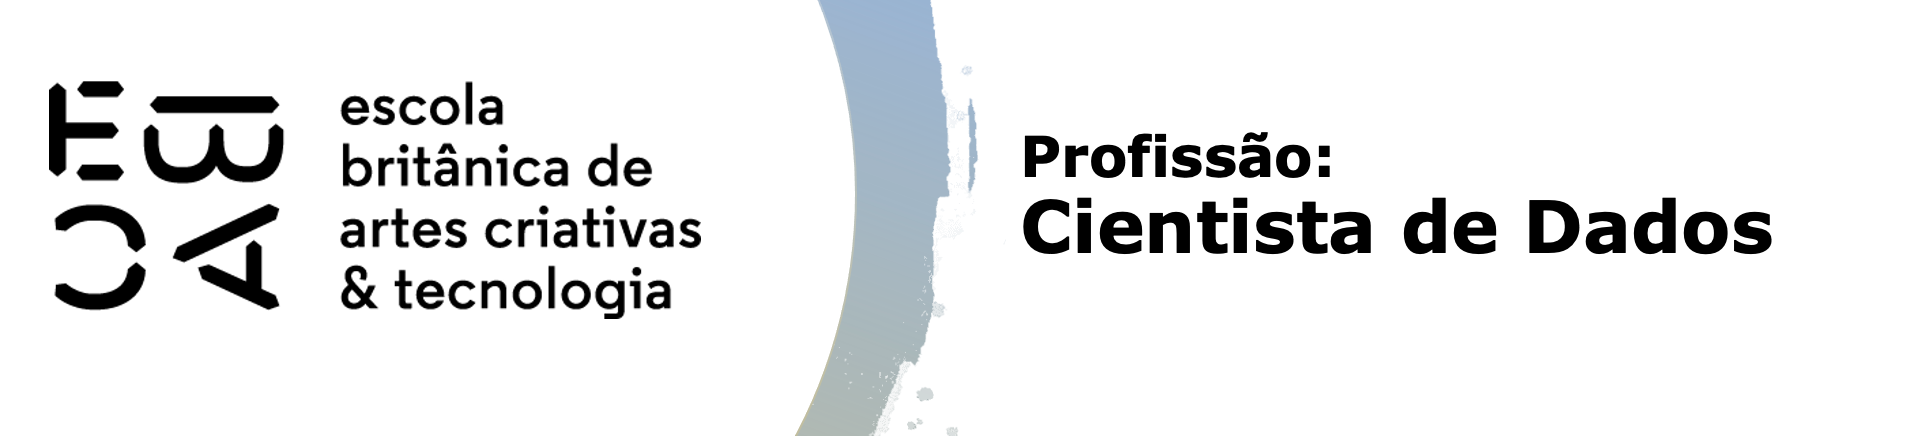

# Árvores II - Tarefa 3

### 1. Carregar as bases

Vamos utilizar nesta tarefa as bases de reconhecimento de atividade humana através do celular. Carregue novamente as bases salvas na tarefa I.

In [55]:
# Importar bibliotecas
import pandas as pd

# Definir os caminhos das bases de dados
dataset_path = r'C:/Users/conta/OneDrive/Área de Trabalho/PAULO/Ciência de Dados/EBAC/Aulas/Arvores II/UCI HAR Dataset/'
csv_path = r'C:/Users/conta/OneDrive/Área de Trabalho/PAULO/Ciência de Dados/EBAC/Aulas/Arvores II/'

# Carregar as bases de dados com o parâmetro atualizado
Y_train = pd.read_csv(dataset_path + 'train/y_train.txt', header=None, names=["activity"], sep=r'\s+').squeeze()
Y_test = pd.read_csv(dataset_path + 'test/y_test.txt', header=None, names=["activity"], sep=r'\s+').squeeze()

# Carregar X_train e X_test como anteriormente
X_train = pd.read_csv(csv_path + 'X_train_subset.csv', index_col=[0, 1])
X_test = pd.read_csv(csv_path + 'X_test_subset.csv', index_col=[0, 1])



### 2. Calcule os ```ccp_alphas```. 

Vamos seguir uma lógica bem em linha com o que já estamso acostumados, com as seguintes orientações:

- Utilizar treinamento e teste conforme já vieram definidos originalmente
- Por pragmatismo, utilizar ```min_samples_leaf=20```
- Utilize as mesmas "3 melhores variáveis" identificadas no exercício anterior.

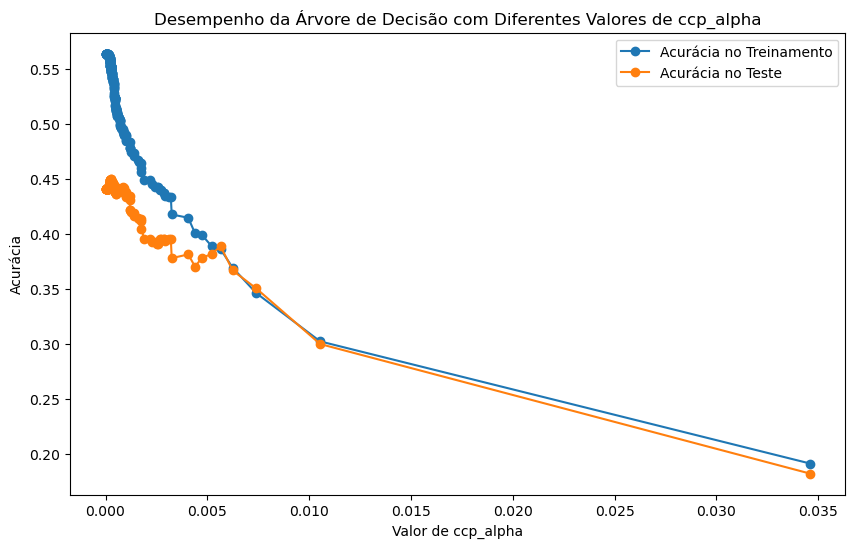

In [59]:
# Avaliar o desempenho para diferentes valores de ccp_alpha
train_scores = []
test_scores = []

# Para cada valor de ccp_alpha, treinar o modelo e calcular a acurácia
for ccp in ccp_alphas:
    model = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp, min_samples_leaf=20)
    model.fit(X_train_ex2, Y_train)
    
    # Calculando as acurácias nos conjuntos de treino e teste
    train_scores.append(model.score(X_train_ex2, Y_train))
    test_scores.append(model.score(X_test_ex2, Y_test))

# Plotando a acurácia para treino e teste
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, train_scores, label="Acurácia no Treinamento", marker="o")
plt.plot(ccp_alphas, test_scores, label="Acurácia no Teste", marker="o")
plt.xlabel("Valor de ccp_alpha")
plt.ylabel("Acurácia")
plt.title("Desempenho da Árvore de Decisão com Diferentes Valores de ccp_alpha")
plt.legend()
plt.show()


### 3. *Grid Search*

Vou deixar especificações iniciais mínimas, que visam limitar o tempo de máquina, pois um procedimento desses pode demorar muito tempo dependendo da especificação. Mas conforme você for ficando confortável com o tempo consumido pelo procedimento, pode fazer um algoritmo mais exaustivo, por exemplo, avaliando mais valores de ```ccp_alpha```.

- Meça o tempo
- Utilize a base de treinamento
- Utilize um *cross validation* do tipo *k-fold*, especifique k=10
- Você pode ler 1 a cada ```k``` valores para uma melhor varredura utilizando, por exemplo, ```ccp_alpha[::10]```
- Não se esqueça de limitar o número de variáveis

In [63]:
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Calcular ccp_alpha
model = DecisionTreeClassifier(random_state=42)
path = model.cost_complexity_pruning_path(X_train_ex2, Y_train)
ccp_alphas = path.ccp_alphas

# Limitar a 1 valor a cada 10 valores de ccp_alpha (para uma melhor varredura)
ccp_alphas_subset = ccp_alphas[::10]

# Definir o GridSearchCV com validação cruzada k-fold (k=10)
param_grid = {'ccp_alpha': ccp_alphas_subset}
grid = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=10)

# Medir o tempo de execução
start_time = time.time()

# Ajustar o modelo
grid.fit(X_train_ex2, Y_train)

# Verificar o melhor modelo encontrado
best_model = grid.best_estimator_

# Tempo de execução
end_time = time.time()
execution_time = end_time - start_time

# Resultados
print(f"Melhor modelo encontrado: {best_model}")
print(f"Melhor ccp_alpha: {grid.best_params_['ccp_alpha']}")
print(f"Tempo de execução: {execution_time:.2f} segundos")


Melhor modelo encontrado: DecisionTreeClassifier(ccp_alpha=0.0005832731672844108, random_state=42)
Melhor ccp_alpha: 0.0005832731672844108
Tempo de execução: 147.68 segundos


### 4. Avaliando a árvore

- Obtenha a árvore na melhor configuração treinada em toda a base de treino
- Calcule a acurácia dessa árvore na base de testes
- Visualize a matriz de confusão

In [48]:
# Prever e avaliar o modelo
y_pred = best_model.predict(X_test_ex2)
cm = confusion_matrix(Y_test, y_pred)

# Calcular a acurácia por classe
for i in range(len(cm)):
    print(f"Classe {best_model.classes_[i]}: {cm[i, i] / cm.sum(axis=1)[i]}")


Classe 1: 0.6169354838709677
Classe 2: 0.24416135881104034
Classe 3: 0.3119047619047619
Classe 4: 0.24236252545824846
Classe 5: 0.5714285714285714
Classe 6: 0.6089385474860335


### 5. Melhorando a árvore

A melhor forma de se melhorar um algoritmo é colocando nele novas variáveis que agreguem valor. Podemos usar a força-bruta e ir colocando variáveis aleatoriamente - ou colocar todas e deixar rodando por um bom tempo - ou utilizar uma lógica eficiente e fazer uma seleção de variáveis.

- Observe que há classes mais fáceis e mais difíceis de se identificar
- Crie uma variável binária para uma das classes de maior erro
- Fala uma árvore de classificação bem simples para esta variável:
    - utilize ```mean_samples_leaf=20```
    - utilize ```max_depth=4```
    - coloque todas as variáveis
- Observe a importância das variáveis, e selecione as 3 com maior importância
- Rode novamente o algoritmo acima com as 3 novas variáveis e avalie a acurácia

Acurácia inicial - Treino: 1.0000, Teste: 0.3699


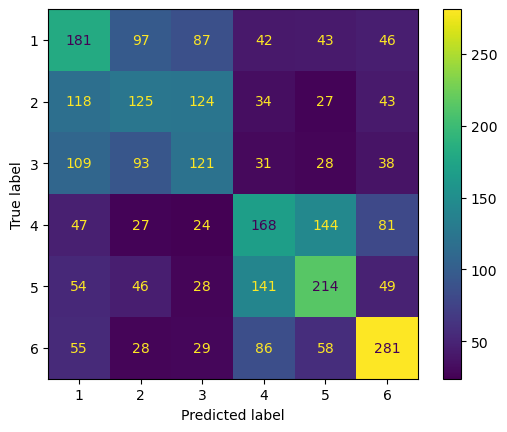

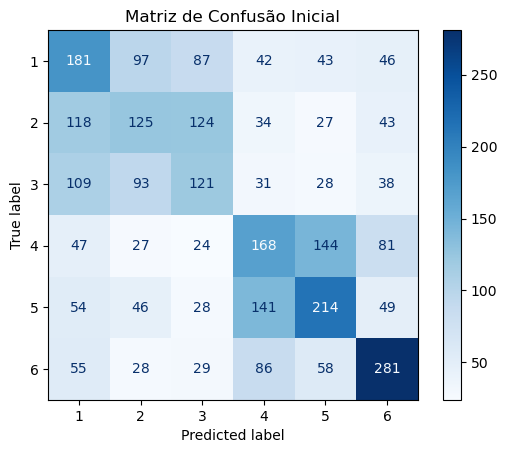

Top 3 variáveis mais importantes: ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z']
Melhor ccp_alpha: 0.00035515657115221854
Acurácia final otimizada: 0.3892


<Figure size 800x600 with 0 Axes>

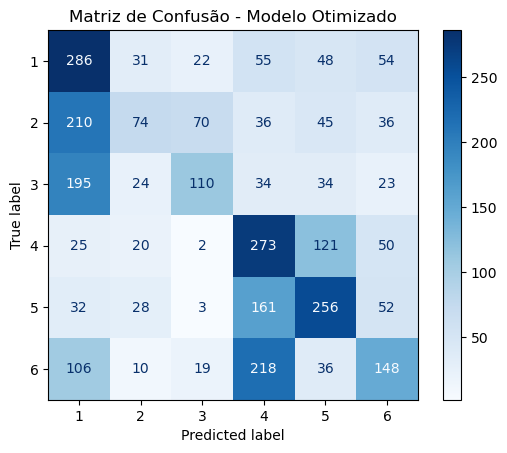

Tempo total de execução: 180.45 segundos


In [17]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix

# Verificar se as variáveis de entrada estão definidas
if 'X_train' not in locals() or 'Y_train' not in locals() or 'X_test' not in locals() or 'Y_test' not in locals():
    raise NameError("As variáveis X_train, Y_train, X_test e Y_test precisam ser definidas antes de rodar este código.")

# Medir tempo de execução
start_time = time.time()

# Modelo inicial e matriz de confusão
model = DecisionTreeClassifier(random_state=42).fit(X_train, Y_train)
print(f"Acurácia inicial - Treino: {model.score(X_train, Y_train):.4f}, Teste: {model.score(X_test, Y_test):.4f}")

# Exibir matriz de confusão inicial
ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test).plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão Inicial")
plt.show()

# Identificar a classe com maior erro
y_pred = model.predict(X_test)
conf_matrix = confusion_matrix(Y_test, y_pred)
errors = conf_matrix.sum(axis=1) - np.diag(conf_matrix)  # Erros por classe
worst_class = np.argmax(errors)  # Classe com maior erro

# Criar variável binária para a classe mais difícil de identificar
Y_train_bin = (Y_train == worst_class).astype(int)
Y_test_bin = (Y_test == worst_class).astype(int)

# Criar uma árvore de decisão simples
simple_tree = DecisionTreeClassifier(random_state=42, min_samples_leaf=20, max_depth=4)
simple_tree.fit(X_train, Y_train_bin)

# Exibir importância das variáveis
feature_importance = pd.Series(simple_tree.feature_importances_, index=X_train.columns)
top_3_features = feature_importance.nlargest(3).index.tolist()
print("Top 3 variáveis mais importantes:", top_3_features)

# Rodar novamente o modelo com as 3 variáveis mais importantes
X_train_selected = X_train[top_3_features]
X_test_selected = X_test[top_3_features]

# Buscar o melhor ccp_alpha para a nova base reduzida
path = DecisionTreeClassifier(random_state=42).fit(X_train_selected, Y_train).cost_complexity_pruning_path(X_train_selected, Y_train)
ccp_alphas = path.ccp_alphas[:-1]  # Exclui o maior alpha para evitar uma árvore vazia

# Criar modelos com diferentes alphas e avaliar acurácia
scores = []
for alpha in ccp_alphas:
    model = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha)
    model.fit(X_train_selected, Y_train)
    scores.append(model.score(X_test_selected, Y_test))

# Escolher o melhor alpha
best_alpha = ccp_alphas[np.argmax(scores)]
print(f"Melhor ccp_alpha: {best_alpha}")

# Aplicar GridSearch novamente com a nova base e melhor alpha
param_grid = {
    "max_depth": [3, 4, 5],
    "min_samples_leaf": [5, 10, 20],
    "ccp_alpha": [best_alpha]
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(X_train_selected, Y_train)

# Avaliação final com modelo otimizado
best_model = grid_search.best_estimator_
final_accuracy = best_model.score(X_test_selected, Y_test)
print(f"Acurácia final otimizada: {final_accuracy:.4f}")

# Matriz de confusão final
y_pred_final = best_model.predict(X_test_selected)
conf_matrix_final = confusion_matrix(Y_test, y_pred_final)

plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(confusion_matrix=conf_matrix_final, display_labels=best_model.classes_).plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão - Modelo Otimizado")
plt.show()

# Tempo total do processo
end_time = time.time()
print(f"Tempo total de execução: {end_time - start_time:.2f} segundos")


**melhoria**

In [65]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd

# Identificar a classe com maior erro
erro_classes = cm.sum(axis=1) - cm.diagonal()
maior_erro_class = erro_classes.argmax()

# Nova variável binária com a classe de maior erro
Y_train_erro = (Y_train == maior_erro_class).astype(int)
Y_test_erro = (Y_test == maior_erro_class).astype(int)

# Re-treinar a árvore com a nova variável binária
clf = DecisionTreeClassifier(random_state=42, min_samples_leaf=20, max_depth=4)
clf.fit(X_train_ex2, Y_train_erro)

# Obter as variáveis mais importantes e selecionar as 3 melhores
var_new = pd.DataFrame(X_train_ex2.columns).rename({0: "Variável"}, axis=1)
var_new["importances"] = clf.feature_importances_
var_new = var_new.sort_values(by="importances", ascending=False)[:3]

# Selecionar as novas variáveis
X_train_ex5 = X_train_ex2[var_new["Variável"]]
X_test_ex5 = X_test_ex2[var_new["Variável"]]

# Re-executar os passos de avaliação
grid.fit(X_train_ex5, Y_train_erro)
best_model = grid.best_estimator_

# Predições e avaliação
y_pred = best_model.predict(X_test_ex5)

# Matriz de Confusão
cm = confusion_matrix(Y_test_erro, y_pred)
print("Matriz de Confusão:")
print(cm)

# Avaliar a acurácia por classe
for i in range(len(cm)):
    print(f"Classe {best_model.classes_[i]}: {cm[i, i] / cm.sum(axis=1)[i]}")

# Exibir a acurácia total
accuracy = accuracy_score(Y_test_erro, y_pred)
print(f'Acurácia total: {accuracy}')


Matriz de Confusão:
[[2510   17]
 [ 382   38]]
Classe 0: 0.9932726553225169
Classe 1: 0.09047619047619047
Acurácia total: 0.8646080760095012
